In [ ]:
import numpy as np
import pandas as pd
import os, sys, random
import tensorflow as tf
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, load_model
import argparse, pickle
from tqdm import tqdm
from collections import deque
import pyautogui as pg
import math, time
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
class MinesweeperEnv(object):
    def __init__(self, width, height, n_mines,
        rewards={'win':1, 'lose':-1, 'progress':0.3, 'guess':-0.3, 'no_progress' : -0.3}):
        self.nrows, self.ncols = width, height
        self.ntiles = self.nrows * self.ncols
        self.n_mines = n_mines
        self.grid = self.init_board()
        self.board = self.get_board()
        self.state, self.state_im = self.init_state()
        self.n_clicks = 0
        self.n_progress = 0
        self.n_wins = 0

        self.rewards = rewards

    def init_board(self):
        board = np.zeros((self.nrows, self.ncols), dtype='object')
        mines = self.n_mines

        while mines > 0:
            row, col = random.randint(0, self.nrows-1), random.randint(0, self.ncols-1)
            if board[row][col] != 'Bomb':
                board[row][col] = 'Bomb'
                mines -= 1

        return board

    def findNeighbors(self, coord):
        """
        returns a list of neighbors
        """
        x,y = coord[0], coord[1]

        neighbors = []
        for col in range(y-1, y+2):
            for row in range(x-1, x+2):
                if ((x != row or y != col) and
                    (0 <= col < self.ncols) and
                    (0 <= row < self.nrows)):
                    neighbors.append(self.grid[row,col])

        return np.array(neighbors)

    def sum_mines(self, coord):
        neighbors = self.findNeighbors(coord)
        return np.sum(neighbors=='Bomb')

    def get_board(self):
        board = self.grid.copy()

        coords = []
        for x in range(self.nrows):
            for y in range(self.ncols):
                if self.grid[x,y] != 'Bomb':
                    coords.append((x,y))

        for coord in coords:
            board[coord] = self.sum_mines(coord)

        return board

    def get_state_im(self, state):
        '''
        Gets the numeric image representation state of the board.
        This is what will be the input for the DQN.
        '''

        state_im = [t['value'] for t in state]
        state_im = np.reshape(state_im, (self.nrows, self.ncols, 1)).astype(object)

        state_im[state_im=='Unknown'] = -1
        state_im[state_im=='Bomb'] = -2

        state_im = state_im.astype(np.int8) / 8
        state_im = state_im.astype(np.float16)

        return state_im

    def init_state(self):
        unsolved_array = np.full((self.nrows, self.ncols), 'Unknown', dtype='object')

        state = []
        for (x, y), value in np.ndenumerate(unsolved_array):
            state.append({'coord': (x, y), 'value':value})

        state_im = self.get_state_im(state)

        return state, state_im

    def click(self, action_index):
        coord = self.state[action_index]['coord']
        value = self.board[coord]

        # ensure first move is not a bomb
        if (value == 'Bomb') and (self.n_clicks == 0):
            grid = self.grid.reshape(1, self.ntiles)
            move = np.random.choice(np.nonzero(grid!='Bomb')[1])
            coord = self.state[move]['coord']
            value = self.board[coord]
            self.state[move]['value'] = value
        else:
            # make state equal to board at given coordinates
            self.state[action_index]['value'] = value

        # reveal all neighbors if value is 0
        if value == 0.0:
            self.reveal_neighbors(coord, clicked_tiles=[])

        self.n_clicks += 1

    def reveal_neighbors(self, coord, clicked_tiles):
        processed = clicked_tiles
        state_df = pd.DataFrame(self.state)
        x,y = coord[0], coord[1]

        neighbors = []
        for col in range(y-1, y+2):
            for row in range(x-1, x+2):
                if ((x != row or y != col) and
                    (0 <= col < self.ncols) and
                    (0 <= row < self.nrows) and
                    ((row, col) not in processed)):

                    # prevent redundancy for adjacent zeros
                    processed.append((row,col))

                    index = state_df.index[state_df['coord'] == (row,col)].tolist()[0]

                    self.state[index]['value'] = self.board[row, col]

                    # recursion in case neighbors are also 0
                    if self.board[row, col] == 0.0:
                        self.reveal_neighbors((row, col), clicked_tiles=processed)

    def reset(self):
        self.n_clicks = 0
        self.n_progress = 0
        self.grid = self.init_board()
        self.board = self.get_board()
        self.state, self.state_im = self.init_state()

    def step(self, action_index):
        done = False
        coords = self.state[action_index]['coord']

        current_state = self.state_im


        # get neighbors before action
        neighbors = self.findNeighbors(coords)

        self.click(action_index)

        # update state image
        new_state_im = self.get_state_im(self.state)
        self.state_im = new_state_im

        if self.state[action_index]['value']=='Bomb': # if lose
            reward = self.rewards['lose']
            done = True

        elif np.sum(new_state_im==-0.125) == self.n_mines: # if win
            reward = self.rewards['win']
            done = True
            self.n_progress += 1
            self.n_wins += 1

        elif np.sum(self.state_im == -0.125) == np.sum(current_state == -0.125):
            reward = self.rewards['no_progress']

        else: # if progress
            if all(t==-0.125 for t in neighbors): # if guess (all neighbors are unsolved)
                reward = self.rewards['guess']

            else:
                reward = self.rewards['progress']
                self.n_progress += 1 # track n of non-isoloated clicks

        return self.state_im, reward, done

    def color_state(self, value):
        if value == -1:
            color = 'red'
        elif value == 0:
            color = 'slategrey'
        elif value == 1:
            color = 'blue'
        elif value == 2:
            color = 'green'
        elif value == 3:
            color = 'purple'
        elif value == 4:
            color = 'midnightblue'
        elif value == 5:
            color = 'brown'
        elif value == 6:
            color = 'aquamarine'
        elif value == 7:
            color = 'black'
        elif value == 8:
            color = 'silver'
        else:
            color = 'magenta'

        return f'color: {color}'

    def draw_state(self, state_im):
        state = state_im
        state_df = pd.DataFrame(state.reshape((self.nrows, self.ncols)), dtype=np.int8)

        display(state_df.style.applymap(self.color_state))

    def render(self):
        s = self.get_board()
        return s


In [ ]:
env = MinesweeperEnv(9,9,10)

In [ ]:
env.get_board()

array([[0, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 'Bomb', 2, 2, 2, 1, 0, 0],
       [0, 1, 1, 3, 'Bomb', 'Bomb', 1, 0, 0],
       [1, 1, 0, 3, 'Bomb', 4, 1, 0, 0],
       ['Bomb', 1, 0, 3, 'Bomb', 4, 1, 2, 1],
       [1, 1, 0, 2, 'Bomb', 3, 'Bomb', 2, 'Bomb'],
       [0, 0, 0, 1, 1, 2, 1, 2, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 'Bomb']], dtype=object)

In [ ]:
arr = env.render()

In [ ]:
for j in range(9):
    for i in range(9):
        if(arr[i][j] == 'Bomb'):
            arr[i][j]=-1
env.draw_state(arr)

,0,1,2,3,4,5,6,7,8
0,0,1,1,1,0,0,0,0,0
1,0,1,-1,2,2,2,1,0,0
2,0,1,1,3,-1,-1,1,0,0
3,1,1,0,3,-1,4,1,0,0
4,-1,1,0,3,-1,4,1,2,1
5,1,1,0,2,-1,3,-1,2,-1
6,0,0,0,1,1,2,1,2,1
7,0,0,0,0,0,0,0,1,1
8,0,0,0,0,0,0,0,1,-1


In [ ]:
def create_model(learn_rate, input_dims, n_actions, conv_units, dense_units):
    model = Sequential([
                Conv2D(conv_units, (3,3), activation='relu', padding='same', input_shape=input_dims),
                Conv2D(conv_units, (3,3), activation='relu', padding='same'),
                Conv2D(conv_units, (3,3), activation='relu', padding='same'),
                Conv2D(conv_units, (3,3), activation='relu', padding='same'),
                Flatten(),  # this converts our 3D feature maps to 1D feature vectors
                Dense(dense_units, activation='relu'),
                Dense(dense_units, activation='relu'),
                Dense(n_actions, activation='linear')])

    model.compile(optimizer=Adam(lr=learn_rate, epsilon=1e-4), loss='mse', metrics=['accuracy'])
    return model

In [ ]:
class ModifiedTensorBoard(TensorBoard):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.create_file_writer(self.log_dir)
        self._log_write_dir = self.log_dir

    def set_model(self, model):
        self.model = model

        self._train_dir = os.path.join(self._log_write_dir, 'train')
        self._train_step = self.model._train_counter

        self._val_dir = os.path.join(self._log_write_dir, 'validation')
        self._val_step = self.model._test_counter

        self._should_write_train_graph = False

    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    def on_batch_end(self, batch, logs=None):
        pass

    def on_train_end(self, _):
        pass

    def update_stats(self, **stats):
        with self.writer.as_default():
            for key, value in stats.items():
                tf.summary.scalar(key, value, step = self.step)
                self.writer.flush()

In [ ]:
ROOT = os.getcwd()
sys.path.insert(1, f'{os.path.dirname(ROOT)}')

# Environment settings
MEM_SIZE = 50_000 # number of moves to store in replay buffer
MEM_SIZE_MIN = 1_000 # min number of moves in replay buffer

# Learning settings
BATCH_SIZE = 64
learn_rate = 0.01
LEARN_DECAY = 0.99975
LEARN_MIN = 0.001
DISCOUNT = 0.1 #gamma

# Exploration settings
epsilon = 0.95
EPSILON_DECAY = 0.99975
EPSILON_MIN = 0.01

# DQN settings
CONV_UNITS = 64 # number of neurons in each conv layer
DENSE_UNITS = 512 # number of neurons in fully connected dense layer
UPDATE_TARGET_EVERY = 5

# Default model name
MODEL_NAME = f'conv{CONV_UNITS}x4_dense{DENSE_UNITS}x2_y{DISCOUNT}_minlr{LEARN_MIN}'

class DQNAgent(object):
    def __init__(self, env, model_name=MODEL_NAME, conv_units=64, dense_units=256):
        self.env = env

        # Deep Q-learning Parameters
        self.discount = DISCOUNT
        self.learn_rate = learn_rate
        self.epsilon = epsilon
        self.model = create_model(
            self.learn_rate, self.env.state_im.shape, self.env.ntiles, conv_units, dense_units)

        # target model - this is what we predict against every step
        self.target_model = create_model(
            self.learn_rate, self.env.state_im.shape, self.env.ntiles, conv_units, dense_units)
        self.target_model.set_weights(self.model.get_weights())


        self.replay_memory = deque(maxlen=MEM_SIZE)
        self.target_update_counter = 0

        self.tensorboard = ModifiedTensorBoard(log_dir=f'logs\\{model_name}', profile_batch=0)

    def get_action(self, state):
        board = state.reshape(1, self.env.ntiles)
        unsolved = [i for i, x in enumerate(board[0]) if x==-0.125]

        rand = np.random.random() # random value b/w 0 & 1

        if rand < self.epsilon: # random move (explore)
            move = np.random.choice(unsolved)
        else:
            moves = self.model.predict(np.reshape(state, (1, self.env.nrows, self.env.ncols, 1)))
            moves[board!=-0.125] = np.min(moves) # set already clicked tiles to min value
            move = np.argmax(moves)

        return move

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, done):
        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MEM_SIZE_MIN:
            return

        # Get a minibatch of random samples from memory replay table
        batch = random.sample(self.replay_memory, BATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in batch])
        current_qs_list = self.model.predict(current_states)

         # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in batch])
        future_qs_list = self.target_model.predict(new_current_states)

        X,y = [], []

        # Now we need to enumerate our batches
        for i, (current_state, action, reward, new_current_state, done) in enumerate(batch):
            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[i])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[i]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X), np.array(y), batch_size=BATCH_SIZE,
                       shuffle=False, verbose=0, callbacks=[self.tensorboard]\
                       if done else None)

        # Update target network counter every episode to determine if we want to update target_model yet
        if done:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

        # decay learn_rate
        self.learn_rate = max(LEARN_MIN, self.learn_rate*LEARN_DECAY)

        # decay epsilon
        self.epsilon = max(EPSILON_MIN, self.epsilon*EPSILON_DECAY)

DQNAgent(MinesweeperEnv(9,9,10))


In [ ]:
ROOT = os.getcwd()
IMGS = f'{ROOT}/pics'

EPSILON = 0.01

CONFIDENCES = {
    'unsolved': 0.99,
    'zero': 0.99,
    'one': 0.95,
    'two': 0.95,
    'three': 0.88,
    'four': 0.95,
    'five': 0.95,
    'six': 0.95,
    'seven': 0.95,
    'eight': 0.95
}

TILES = {
    'Unknown': 'unsolved',
    '0': 'zero',
    '1': 'one',
    '2': 'two',
    '3': 'three',
    '4': 'four',
    '5': 'five',
    '6': 'six',
    '7': 'seven',
    '8': 'eight',
}

class MinesweeperAgentWeb(object):
    def __init__(self, model,
                 rewards={'win':1, 'lose':-1, 'progress':0.3, 'guess':-0.3, 'no_progress' : -0.3}):
        pg.click((1,10)) # click on current tab so 'F2' resets the game
        pg.press('f2') # to reset the game
        self.mode, self.loc, self.dims = self.get_loc()
        self.nrows, self.ncols = self.dims[0], self.dims[1]
        self.ntiles = self.dims[2]
        self.board = self.get_board(self.loc)
        self.state = self.get_state(self.board)

        self.epsilon = EPSILON
        self.model = model
        self.rewards = rewards
        self.tensorboard = ModifiedTensorBoard(log_dir=f'logs\\{MODEL_NAME}', profile_batch=0)

    def get_loc(self):
        '''
        obtain mode, screen coordinates and dimensions for Minesweeper board
        '''
        modes = {'beginner':(9,9,81), 'intermediate':(16,16,256), 'expert':(16,30,480)}
        boards = {mode: pg.locateOnScreen(f'{IMGS}/{mode}.png') for mode in modes.keys()}

        assert boards != {'beginner':None, 'intermediate':None, 'expert':None},\
            'Minesweeper doesn\'t exist'

        for mode in boards.keys():
            if boards[mode] != None:
                diff = mode
                loc = boards[mode]
                dims = modes[mode]

        return diff, loc, dims

    def get_tiles(self, tile, bbox):
        '''
        Gets all locations of a given tile.
        Different confidence values are needed to correctly find different tiles with grayscale=True
        '''
        conf = CONFIDENCES[tile]
        tiles = list(pg.locateAllOnScreen(f'{IMGS}/{tile}.png', region=bbox, grayscale=True, confidence=conf))
        return tiles

    def get_board(self, bbox):
        '''
        Gets the state of the board as a dictionary of coordinates and values,
        ordered from left to right, top to bottom
        '''

        all_tiles = [[t, self.get_tiles(TILES[t], self.loc)] for t in TILES]

        tiles = []
        for value, coords in all_tiles:
            for coord in coords:
                tiles.append({'coord': (coord[0], coord[1]), 'value': value})

        tiles = sorted(tiles, key=lambda x: (x['coord'][1], x['coord'][0]))

        i=0
        for x in range(self.nrows):
            for y in range(self.ncols):
                tiles[i]['index'] = (y, x)

        return tiles

    def get_state(self, board):
        '''
        Gets the numeric image representation state of the board.
        This is what will be the input for the DQN.
        '''
        state_im = [t['value'] for t in board]
        state_im = np.reshape(state_im, (self.nrows, self.ncols, 1)).astype(object)

        state_im[state_im=='Unknown'] = -1
        state_im[state_im=='Bomb'] = -2

        state_im = state_im.astype(np.int8) / 8
        state_im = state_im.astype(np.float16)

        return state_im

    def get_action(self, state):
        board = self.state.reshape(1, self.ntiles)
        unsolved = [i for i, x in enumerate(board[0]) if x==-0.125]

        rand = np.random.random() # random value b/w 0 & 1

        if rand < self.epsilon: # random move (explore)
             move = np.random.choice(unsolved)
        else:
            moves = self.model.predict(np.reshape(self.state, (1, self.nrows, self.ncols, 1)))
            moves[board!=-0.125] = np.min(moves)
            move = np.argmax(moves)
        return move

    def findNeighbors(self, action_index):
        """
        returns a list of neighbors
        """
        board_2d = [t['value'] for t in self.board]
        board_2d = np.reshape(board_2d, (self.nrows, self.ncols))
        tile = (action_index/9,action_index%9)
        x,y = math.ceil(tile[0]), math.ceil(tile[1])
        neighbors = []
        for col in range(y-1, y+2):
            for row in range(x-1, x+2):
                if (-1 < x < self.nrows and
                    -1 < y < self.ncols and
                    (x != row or y != col) and
                    (0 <= col < self.ncols) and
                    (0 <= row < self.nrows)):
                    neighbors.append(board_2d[col,row])

        return neighbors

    def step(self, action_index):
        done = False

        # get neighbors before clicking
        neighbors = self.findNeighbors(action_index)
        current_state = self.state


        pg.click(self.board[action_index]['coord'])

        new_state = self.get_state(self.board)

        if pg.locateOnScreen(f'{IMGS}/lose.png', region=self.loc) != None: # if lose
            reward = self.rewards['lose']
            done = True

        elif pg.locateOnScreen(f'{IMGS}/win.png', region=self.loc) != None: # if win
            reward = self.rewards['win']
            done = True

        elif np.sum(self.state == -0.125) == np.sum(current_state == -0.125):
            reward = self.rewards['no_progress']
            self.board = self.get_board(self.loc)
            self.state = self.get_state(self.board)

        else: # if progress
            if all(t==-0.125 for t in neighbors): # if guess (all neighbors are unsolved)
                reward = self.rewards['guess']

            else:
                reward = self.rewards['progress']
            self.board = self.get_board(self.loc)
            self.state = self.get_state(self.board)

        return self.state,reward, done





In [ ]:
import sys
sys.argv=['']
del sys

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def parse_args():
    parser = argparse.ArgumentParser(description='Train a DQN to play Minesweeper')
    parser.add_argument('--width', type=int, default=9,
                        help='width of the board')
    parser.add_argument('--height', type=int, default=9,
                        help='height of the board')
    parser.add_argument('--n_mines', type=int, default=10,
                        help='Number of mines on the board')
    parser.add_argument('--episodes', type=int, default=3000,
                        help='Number of episodes to train on')
    parser.add_argument('--model_name', type=str, default=f'{MODEL_NAME}',
                        help='Name of model')

    return parser.parse_args()

def parse_args_test():
    parser = argparse.ArgumentParser(description='Play Minesweeper online using a DQN')
    parser.add_argument('--model', type=str, default='conv64x4_dense512x2_y0.1_minlr0.001',
                        help='name of model')
    parser.add_argument('--episodes', type=int, default=5,
                        help='Number of episodes to play')
    return parser.parse_args()

In [ ]:
def test(stat_dataframe):
    params_test = parse_args_test()
    ep_rewards,time_step=[],[]
    my_model = load_model(f'models/{params_test.model}.h5')
    agent_test = MinesweeperAgentWeb(my_model)
    ep = 0

    for episode in range(1, params_test.episodes+1):
        ep = ep+1
        pg.press('f2') #reset the game

        cumu_reward = 0
        total_step = 0

        done = False
        while not done:
            current_state = agent_test.state
            action = agent_test.get_action(current_state)
            total_step += 1
            new_state, reward ,done = agent_test.step(action)
            cumu_reward += reward
        ep_rewards.append(cumu_reward)
        time_step.append(total_step)

    mean_time_step = round(np.mean(time_step), 2)
    mean_reward = round(np.mean(ep_rewards), 2)

    stat_dataframe=stat_dataframe.append({ 'mean_time_step': float(mean_time_step),
                                            'mean_reward': float(mean_reward)}, ignore_index=True,)
    return stat_dataframe


In [ ]:
params = parse_args()
params_test = parse_args_test()
env = MinesweeperEnv(params.width, params.height, params.n_mines)
agent = DQNAgent(env, params.model_name)

df_test = pd.DataFrame(columns=[ 'mean_time_step', 'mean_reward'])
df = pd.DataFrame(columns=[ 'time_step', 'reward'])

progress_list, wins_list, ep_rewards = [], [], []
n_clicks = 0
frame_idx = 0

# Iterate over episodes
for episode in tqdm(range(1, params.episodes+1), unit='episode'):
    # Update tensorboard step every episode
    time_step = 0
    agent.tensorboard.step = episode
    # Reset environment and get initial state
    env.reset()
    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    past_n_wins = env.n_wins
    frame_idx += 1

    # Reset flag and start iterating until episode ends
    done = False
    while not done:
        current_state = env.state_im

        action = agent.get_action(current_state)

        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done)

        n_clicks += 1
        time_step+=1

    df = df.append({ 'time_step': float(time_step),
                'reward': float(episode_reward)}, ignore_index=True,)



    if episode % 10 == 0:
        with open(f'replay/{MODEL_NAME}.pkl', 'wb') as output:
            pickle.dump(agent.replay_memory, output)

        agent.model.save(f'models/{MODEL_NAME}.h5')
        df_test = test(df_test)


In [ ]:
def plot_test(df):
    df['Episode'] = df.index
    plt.figure(figsize=(10,6))
    plt.title("the number of time-steps required to solve the task per episode (Test)", fontsize=14, fontweight='bold')
    ax1 = sns.lineplot(x="Episode", y="mean_time_step", data=df)
    plt.hlines(min(df["mean_time_step"]), 0, len(df), colors = "r", linestyles = "dashed")
    plt.show()

    plt.figure(figsize=(10,6))
    plt.title("Cumulative reward per episode obtained by the agent (Test)", fontsize=14, fontweight='bold')
    ax2 = sns.lineplot(x="Episode", y="mean_reward", data=df)
    plt.hlines(max(df["mean_reward"]), 0, len(df), colors = "r", linestyles = "dashed")
    plt.show()

In [ ]:
def plot_train(df):
    df['Episode'] = df.index
    plt.figure(figsize=(10,6))
    plt.title("the number of time-steps required to solve the task per episode (Train)", fontsize=14, fontweight='bold')
    ax1 = sns.lineplot(x="Episode", y="time_step", data=df)
    plt.hlines(min(df["time_step"]), 0, len(df), colors = "r", linestyles = "dashed")
    plt.show()

    plt.figure(figsize=(10,6))
    plt.title("Cumulative reward per episode obtained by the agent (Train)", fontsize=14, fontweight='bold')
    ax2 = sns.lineplot(x="Episode", y="reward", data=df)
    plt.hlines(max(df["reward"]), 0, len(df), colors = "r", linestyles = "dashed")
    plt.show()

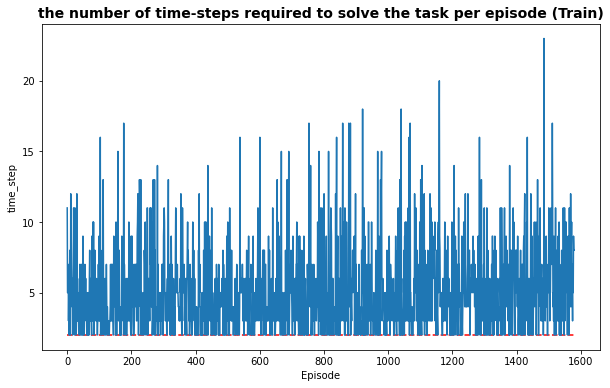

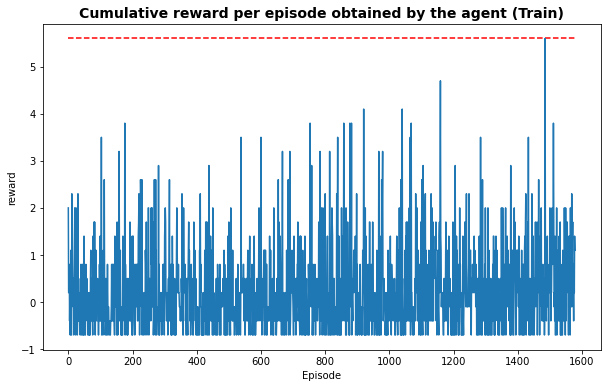

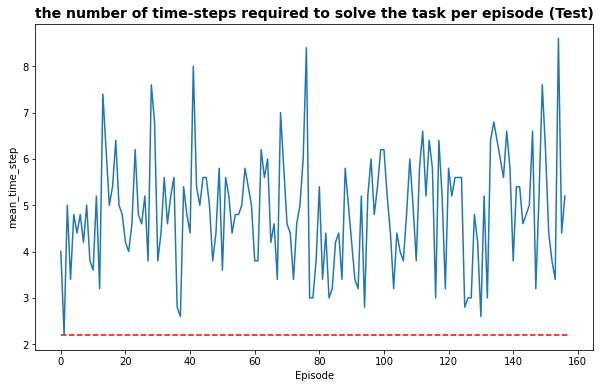

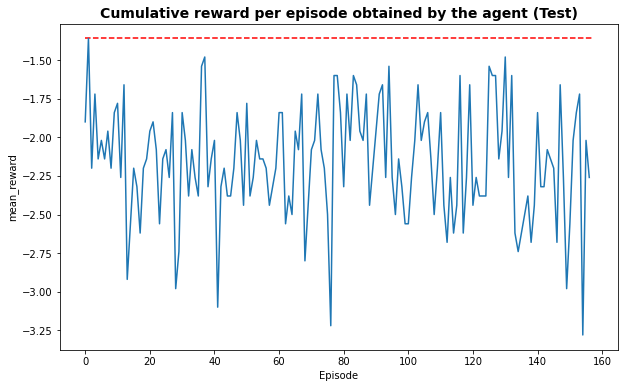

In [ ]:
plot_train(df)
plot_test(df_test)